# Generate data for the smooth bathymetry runs

In [1]:
import os.path as osp
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import xgcm
import xmitgcm
import MITgcmutils.mds as mds
import cmocean.cm as cmo
from dask.distributed import Client, LocalCluster

In [2]:
def import_dask():
    from dask_jobqueue import SLURMCluster
    scluster = SLURMCluster(queue='standard',
                        project="n01-siAMOC",
                        job_cpu=128,
                        cores=128,
                        processes=32,
                        memory="256 GB",
                        header_skip= ['#SBATCH --mem='],
                        walltime="00:20:00",
                        #walltime="04:00:00",
                        death_timeout=60,
                        interface='hsn0',
                        job_extra=['--qos=short', '--reservation=shortqos'],
                        #job_extra=['--qos=standard'],
                        env_extra=['module load cray-python',
                                   'source /work/n01/n01/fwg/venvs/parallel-base/bin/activate'])
                        #extra=['--host ${SLURMD_NODENAME}'])

    print(scluster.job_script())

    client = Client(scluster)

    scluster.scale(jobs=1)
    
    return client, scluster

try:
    client, scluster = import_dask()
except ModuleNotFoundError:
    pass

/mnt/lustre/a2fs-work1/work/n01/n01/fwg/venvs/parallel-base/lib/python3.8/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -p standard
#SBATCH -A n01-siAMOC
#SBATCH -n 1
#SBATCH --cpus-per-task=128
#SBATCH -t 00:20:00
#SBATCH --qos=short
#SBATCH --reservation=shortqos
module load cray-python
source /work/n01/n01/fwg/venvs/parallel-base/bin/activate
/mnt/lustre/a2fs-work1/work/n01/n01/fwg/venvs/parallel-base/bin/python -m distributed.cli.dask_worker tcp://10.253.2.72:38219 --nthreads 4 --nprocs 32 --memory-limit 7.45GiB --name dummy-name --nanny --death-timeout 60 --interface hsn0 --protocol tcp://



## Original dataset manipulations
Here we open the original dataset, reformat it and then plot the mean density and velocity

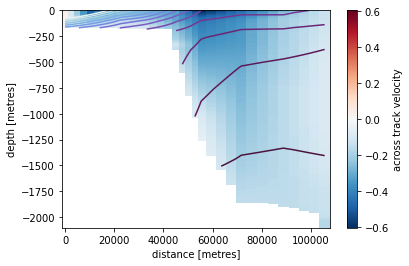

In [3]:
def open_observational_data():
    # Open the original dataset
    ds_orig = xr.open_dataset('CFall_finergrid_2m.nc', chunks=-1)
    ds_orig = ds_orig.transpose('date', 'depth', 'distance', ...)
    ds_orig

    # Reformat the original dataset
    ds = ds_orig.copy(deep=True)

    ds['distance'] = (ds['distance'] - ds['distance'].isel(distance=0)) * 1e3
    ds['distance'].attrs = {'units': 'metres'}

    ds['depth'] = - ds['depth']
    ds['depth'].attrs = {'units': 'metres', 'convention': 'depth increases towards the surface'}

    return ds

try:
    ds_mean = xr.open_dataset('MeanData.nc')
except FileNotFoundError:
    ds_mean = open_observational_data().mean(dim='date').load()
    ds_mean.to_netcdf('MeanData.nc')

fig, ax = plt.subplots()

cax0 = ds_mean['across track velocity'].plot(ax=ax)
cax1 = ds_mean['potential density'].plot.contour(ax=ax, levels=np.arange(26.5, 28, 0.1), cmap=cmo.dense)

fig.show()

## Create the model grid

In [4]:
# User defined grid parameters
H_min = -1900
Lx = 600e3 ## Set to 600e3
Ly = 1800e3  # Large is 3000e3

dz = 4
dx = 1e3
dy = 1e3

# Dataset creation
ny = int(Ly / dy)
nz = int(-H_min / dz)
nx = int(Lx / dx)

def create_grids():
    drF = -dz * np.ones(nz)

    xg = np.linspace(-0.5 * dx, Lx - 0.5 * dx, nx)  # Coordinate of left, u points
    xc = xg + dx * 0.5  # Coordinate of right v, eta, rho and h points

    xg_reversed = xg[::-1]
    xc_reversed = xc[::-1]
    
    yg = np.linspace(-0.5 * dy, Ly - 0.5 * dy, ny)  # Coordinate of left, u points
    yc = yg + dy * 0.5  # Coordinate of right v, eta, rho and h points

    zu = np.cumsum(drF)  # This is the lower coordinate of the vertical cell faces, i.e. the w points
    zl = np.concatenate(([0], zu[:-1]))  # This is the upper coordinate of the vertical cell faces
    z = 0.5 * (zl + zu)  # Vertical coordiante of the velocity points


    ds_grid = xr.Dataset(coords={'XG': xg,
                                 'XC': xc,
                                 'YG': yg,
                                 'YC': yc,
                                 'Zu': zu,
                                 'Zl': zl,
                                 'Z': z})
    grid = xgcm.Grid(ds_grid,
                     periodic=['X'],
                     coords={'X': {'left': 'XG', 'center': 'XC'},
                             'Y': {'left': 'YG', 'center': 'YC'},
                             'Z': {'left': 'Zu', 'right': 'Zl', 'center': 'Z'}})
    
    ds_reversed_xgrid = xr.Dataset(coords={'XG': xg_reversed,
                                           'XC': xc_reversed,
                                           'YG': yg,
                                           'YC': yc,
                                           'Zu': zu,
                                           'Zl': zl,
                                           'Z': z})
    
    reversed_xgrid = xgcm.Grid(ds_reversed_xgrid,
                     periodic=['X'],
                     coords={'X': {'left': 'XG', 'center': 'XC'},
                             'Y': {'left': 'YG', 'center': 'YC'},
                             'Z': {'left': 'Zu', 'right': 'Zl', 'center': 'Z'}})
    
    
    ds_reversed_zgrid = xr.Dataset(coords={'XG': xg,
                                           'XC': xc,
                                           'YG': yg,
                                           'YC': yc,
                                           'Zu': zu[::-1],
                                           'Zl': zl[::-1],
                                           'Z': z[::-1]})
    
    reversed_zgrid = xgcm.Grid(ds_reversed_zgrid,
                     periodic=['X'],
                     coords={'X': {'left': 'XG', 'center': 'XC'},
                             'Y': {'left': 'YG', 'center': 'YC'},
                             'Z': {'left': 'Zu', 'right': 'Zl', 'center': 'Z'}})
    
    ds_grid['deltaX'] = ('XC', dx * np.ones(nx))
    ds_grid['deltaY'] = ('YC', dy * np.ones(ny))
    ds_grid['deltaZ'] = ('Z', dz * np.ones(nz))
    
    return ds_grid, grid, reversed_xgrid, reversed_zgrid

ds_grid, grid, reversed_xgrid, reversed_zgrid = create_grids()
ds_input = ds_grid.copy(deep=True)

In [5]:
ds_grid

<xarray.Dataset>
Dimensions:  (XG: 600, XC: 600, YG: 1800, YC: 1800, Zu: 475, Zl: 475, Z: 475)
Coordinates:
  * XG       (XG) float64 -500.0 501.7 1.503e+03 ... 5.985e+05 5.995e+05
  * XC       (XC) float64 0.0 1.002e+03 2.003e+03 ... 5.98e+05 5.99e+05 6e+05
  * YG       (YG) float64 -500.0 500.6 1.501e+03 ... 1.797e+06 1.798e+06 1.8e+06
  * YC       (YC) float64 0.0 1.001e+03 2.001e+03 ... 1.799e+06 1.8e+06
  * Zu       (Zu) float64 -4.0 -8.0 -12.0 ... -1.892e+03 -1.896e+03 -1.9e+03
  * Zl       (Zl) float64 0.0 -4.0 -8.0 ... -1.888e+03 -1.892e+03 -1.896e+03
  * Z        (Z) float64 -2.0 -6.0 -10.0 ... -1.89e+03 -1.894e+03 -1.898e+03
Data variables:
    deltaX   (XC) float64 1e+03 1e+03 1e+03 1e+03 ... 1e+03 1e+03 1e+03 1e+03
    deltaY   (YC) float64 1e+03 1e+03 1e+03 1e+03 ... 1e+03 1e+03 1e+03 1e+03
    deltaZ   (Z) float64 4.0 4.0 4.0 4.0 4.0 4.0 4.0 ... 4.0 4.0 4.0 4.0 4.0 4.0

In [6]:
grid

<xgcm.Grid>
X Axis (periodic, boundary=None):
  * left     XG --> center
  * center   XC --> left
Y Axis (not periodic, boundary=None):
  * left     YG --> center
  * center   YC --> left
Z Axis (not periodic, boundary=None):
  * left     Zu --> center
  * right    Zl --> center
  * center   Z --> left

## Create the idealised bathymetry
Now we want to fit an idealised curve to this data. We will try something of the form

$$h = h_0 (e^{- \lambda x} - 1) - h_1 \Bigg[\tanh\bigg(\frac{x - x_{mid}}{\delta}\bigg) + 1\Bigg]$$

Where all the fitted parameters are required to be positive and with

$$H_{min} = -2 h_1 - h_0$$

where $H_{min}$ must be chosen by hand.

Close to the coast the first term dominates giving an initial steep fall in depth. Further away the tanh term takes over.

We fit the data using the `scipy` function `curve_fit` which minimises the residuals between the observations and the fitted profile. We set an upper bound on the paramater $\lambda$ of $0.5 \times 10^{-3}$ m$^{-1}$ corresponding to a minimum bathymetric 'decay rate' of 2 km close to the surface, preventing the slope from being too steep.

In [7]:
def produce_depth():
    ds_depth = xr.Dataset(coords={'distance': ds_mean['distance'],
                                  'depth': ds_mean['depth']})

    # Extract the depth data from the 2D field
    ds_depth['2d_depth'] = ds_depth['distance'] * ds_depth['depth']
    ds_depth['2d_depth'] = ds_depth['2d_depth'] + (0 * ds_mean['potential density'])
    depth_args = ds_depth['2d_depth'].argmax('depth', skipna=False)
    ds_depth['h'] = ds_depth['depth'].isel(depth=depth_args)
    ds_depth['h'].values[0] = 0  # Set the depth at the first grid cell to zero
    return ds_depth

ds_depth = produce_depth()
ds_depth

<xarray.Dataset>
Dimensions:   (distance: 33, depth: 1052)
Coordinates:
  * distance  (distance) float64 0.0 2.5e+03 5e+03 ... 1.013e+05 1.055e+05
  * depth     (depth) float64 -0.0 -2.0 -4.0 ... -2.098e+03 -2.1e+03 -2.102e+03
Data variables:
    2d_depth  (distance, depth) float64 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan
    h         (distance) float64 0.0 -170.0 -170.0 ... -1.964e+03 -1.988e+03

h_0 = 152.45, lambda = 5.00e-04, x_mid = 53526.25, delta = 10733.05


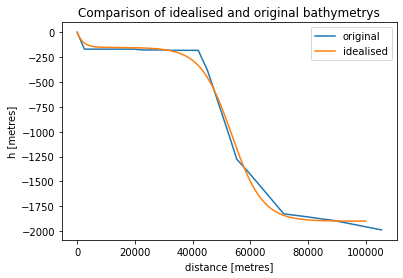

In [8]:
from scipy.optimize import curve_fit

def depth_function(x, h0, lambdaa, xm, delta):
    h1 = - 0.5 * (H_min + h0)
    h_upper = h0 * (np.exp(-x * lambdaa) - 1)
    h_lower =  - h1 * (np.tanh((x - xm) / delta) + 1)
    return h_upper + h_lower

params, _ = curve_fit(depth_function, ds_depth['distance'], ds_depth['h'],
                      bounds=(0, (np.inf, 1/2e3, np.inf, np.inf)),
                      p0=(250, 1/10e3, 40e3, 30e3))

def plot_the_idealised_bathmetry():
    # Evaluate the idealised depth function
    X = np.linspace(0, 100e3, 400)
    idealised_depth = depth_function(X, *params)

    # Plot the observed depth and idealised depth together.
    fig, ax = plt.subplots()
    ds_depth['h'].plot(label='original', ax=ax)
    ax.plot(X, idealised_depth, label='idealised')
    ax.legend()
    ax.set_title("Comparison of idealised and original bathymetrys")
    fig.show()

    print('h_0 = {:.2f}, lambda = {:.2e}, x_mid = {:.2f}, delta = {:.2f}'.format(*params))
    
plot_the_idealised_bathmetry()

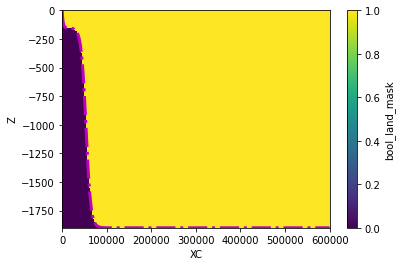

In [9]:
# Make and plot the bathymetry masks
ds_input['bathymetry'] = xr.DataArray(depth_function(ds_input['XC'], *params))
ds_input['bathymetry'].plot(lw=3, c='m', ls='-.')

ds_input['bool_land_mask'] = xr.where(ds_input['bathymetry'] <= ds_input['Z'], 1, 0)
ds_input['nan_land_mask'] = xr.where(ds_input['bathymetry'] <= ds_input['Z'], 1, np.nan)

ds_input['bool_land_mask'].plot()

## Interpolate to the smooth grid

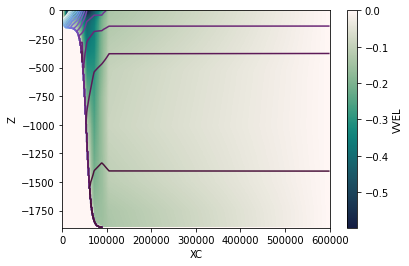

In [10]:
def calculate_bottom_indices():
    # Land masked depth
    depth_land_masked = ds_input['bool_land_mask'] * ds_input['Z']
    bottom_depth_indices = depth_land_masked.argmin('Z')    
    return bottom_depth_indices

bottom_depth_indices = calculate_bottom_indices()

east_boundary_vvel = xr.zeros_like(ds_input['Z'])
bottom_boundary_vvel = xr.zeros_like(ds_input['XC'])

east_boundary_density = ds_mean['potential density'].isel(distance=-1).interp({'depth': ds_input['Z']})
bottom_boundary_density = 'density'

def put_da_on_ideal_grid(da, east_boundary_values, bottom_boundary_values):
    if type(bottom_boundary_values) == str:
        if bottom_boundary_values == 'density':
            density = True
        else:
            raise ValueError("`bottom_boundary_values` must be 'density' or array like")
    else:
        density = False
    
    da_model_grid = da.interp({'distance': ds_input['XC'], 'depth': ds_input['Z']})
    
    # Set the array values at the bottom and eastern boundaries
    if density:
        da_model_grid[bottom_depth_indices] = xr.full_like(ds_input['XC'], np.nan)
    else:
        da_model_grid[bottom_depth_indices] = bottom_boundary_values

    da_model_grid[:, -1] = east_boundary_values
    
    if density:
        da_filled = da_model_grid[::-1].interpolate_na(dim='Z', method='linear', fill_value='extrapolate')[::-1]
        da_filled = da_filled.interpolate_na(dim='XC', method='linear')

    else:
        da_filled = da_model_grid[::-1].interpolate_na(dim='Z', method='linear')[::-1]
        da_filled = da_filled.interpolate_na(dim='XC', method='linear')
    
    # Remove the extra grid points
    da_on_ideal_grid = ds_input['nan_land_mask'] * da_filled
    da_on_ideal_grid = da_on_ideal_grid.fillna(0)
    return da_on_ideal_grid

ds_input['VVEL'] = put_da_on_ideal_grid(ds_mean['across track velocity'], east_boundary_vvel, bottom_boundary_vvel)
ds_input['sigma'] = put_da_on_ideal_grid(ds_mean['potential density'], east_boundary_density, bottom_boundary_density)

fig, ax = plt.subplots()
ds_input['VVEL'].plot(ax=ax, cmap=cmo.tempo_r)
ds_input['sigma'].plot.contour(levels=np.arange(26.5, 28, 0.1), ax=ax, cmap=cmo.dense)
fig.show()

## An idealised approach

The density profile created by interpolation is not smooth and is unstable in places. The velocity profile is also a little strange. To get around this we can prescribe an idealised velocity profile and by putting it in thermal wind balance extract a density profile

### The velocity

We will chose a velocity profile that is given by

$$V = V_L(x, z) + V_r(x, z)$$

where 

$$V_i = V_0 \exp\bigg[ - \frac{(x - x_m) ^ 2}{2 \sigma_{x}^2} \bigg] \bigg(\frac{Z - Z_m}{\sigma_z} + 1\bigg)$$

We fit the parameters by eye to create jets similar to those in the observations

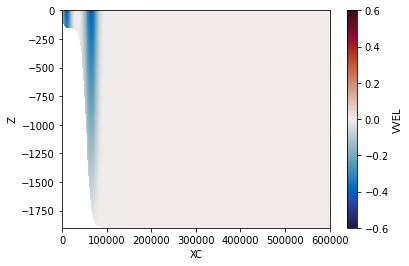

In [11]:
def input_velocity(X, Z, mask=None):
    V0L = -0.2
    V0L = -0.4
    xmL = 10e3
    sigmaxL = 7e3
    zmL = - 0
    sigmazL = 750
    
    V0R = -0.6
    V0R = -0.4
    xmR = 65e3
    sigmaxR = 10e3
    zmR = - 0
    sigmazR = - H_min

    VL = gaussian_jet(X, Z, V0L, xmL, sigmaxL, zmL, sigmazL)
    VR = gaussian_jet(X, Z, V0R, xmR, sigmaxR, zmR, sigmazR)
    
    V = VL + VR
    if mask is not None:
        V = V * ds_input['nan_land_mask']
    return V


def gaussian_jet(X, Z, V0, Xmid, sigmaX, Zmid, sigmaZ):
    VZ = (Z - Zmid) / sigmaZ + 1
    VX = np.exp(-np.square(X - Xmid) / 2 / np.square(sigmaX))
    V = V0 * VZ * VX
    return V

ds_input['VVEL'] = input_velocity(ds_input['XC'], ds_input['Z'], mask=ds_input['nan_land_mask'])
ds_input['VVEL'].plot(cmap=cmo.balance, vmin=-0.6, vmax=0.6)
ds_input['UVEL'] = xr.zeros_like(ds_input['Z'] * ds_input['XG'])

### The density

We get the density profile by using thermal wind balance. When we integrate we do so from the eastern boundary to avoid weird western boundary effects.

#### Reference density profile

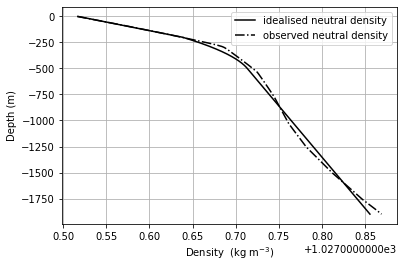

rho_0 = 1027.5173032872965


In [12]:
from scipy.interpolate import interp1d
from scipy.stats import linregress
from scipy.linalg import solve

def create_idealised_reference_density(observed_reference_density):
    # Set the depths at which to switch profiles
    z_therm = -200 + 1e-7 # Depth at which the linaar surface profile ends
    z_bound = -500 + 1e-7 # Depth at which the linear deep profile starts

    surf_rho = observed_reference_density.sel(Z=slice(0, z_therm))
    mid_rho = observed_reference_density.sel(Z=slice(z_therm, z_bound))
    deep_rho = observed_reference_density.sel(Z=slice(z_bound, H_min))

    # Use observations to linearly fit the deep profile
    k2, c2 = deep_rho.polyfit('Z', 1)['polyfit_coefficients']
    interp_deep_rho = k2 * deep_rho['Z'] + c2

    # Use observations to linearly fit the surface profile
    k1, c1 = surf_rho.polyfit('Z', 1)['polyfit_coefficients']
    interp_surf_rho = k1 * surf_rho['Z'] + c1

    # Fit a second order polynomial to the middle density profile
    # Match the density and its derivative at the boundary layer
    # Match the the density, but not its derivative at the the thermocline
    rho_therm = k1 * z_therm + c1
    rho_bound = k2 * z_bound + c2
    A = np.array([[z_therm ** 2 , z_therm, 1],[z_bound ** 2, z_bound, 1],[2 * z_bound, 1, 0]])
    bprime = np.array([rho_therm, rho_bound, k2])
    a, b, c = solve(A, bprime)  # rho = a * z ** 2 + b * z + c
    interp_mid_rho = a * mid_rho['Z'] * mid_rho['Z']  + b * mid_rho['Z'] + c
    
    ds_input['rho_ref'] = xr.concat([interp_surf_rho, interp_mid_rho, interp_deep_rho], dim='Z')

    rho_0 = ds_input['rho_ref'][0].values

    plt.plot(ds_input['rho_ref'], ds_input['Z'], c='k', ls='-', label='idealised neutral density')
    plt.plot(observed_reference_density, observed_reference_density['Z'], c='k', ls='-.', label='observed neutral density')


    plt.xlabel('Density  (kg m$^{-3}$)')
    plt.ylabel('Depth (m)')
    plt.grid()
    plt.legend()
    plt.show()

    print('rho_0 =', rho_0)
    
create_idealised_reference_density(ds_input['sigma'].isel(XC=-1) + 1000)

stratification is stable


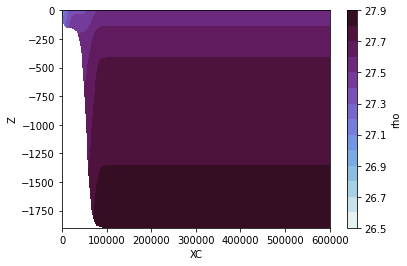

In [13]:
rho_0 = 1000
g = 9.81
f = 1.26e-4

def create_idealized_density(ds_input, rho_ref):
    V = input_velocity(ds_input['XG'], ds_input['Zl'])
    dv_dz = grid.diff(V, 'Z', boundary='extrapolate')
    drho_dx = - f * rho_0 / g * dv_dz

    rho = rho_ref + reversed_xgrid.cumsum(drho_dx[:, ::-1], 'X') * dx * 0.5
    rho = rho * ds_input['nan_land_mask']
    return rho

ds_input['rho'] = create_idealized_density(ds_input, ds_input['rho_ref'])
(ds_input['rho'] - 1000).plot(cmap=cmo.dense, levels=np.arange(26.5, 28, 0.1))

if xr.where(ds_input['rho'].diff('Z') < 0, 1, 0).sum() != 0:
    print('stratification is unstable')
    print(xr.where(ds_input['rho'].diff('Z') < 0, 1, 0).sum().values)
else:
    print('stratification is stable')

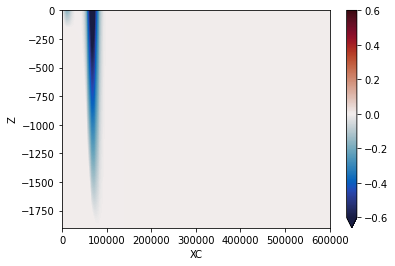

In [14]:
db_dx = g / rho_0 * grid.diff(ds_input['rho'], 'X') / dx
db_dx_interp = grid.interp(db_dx, ['X', 'Z'], boundary='fill')

V = reversed_zgrid.cumsum(db_dx_interp[::-1], 'Z') * -dz / f
V.plot(vmin=-0.6, vmax=0.6, cmap=cmo.balance)

try:
    ds_input['VVEL_orig']
except:
    ds_input['VVEL_orig'] = ds_input['VVEL']

ds_input['VVEL'] = V

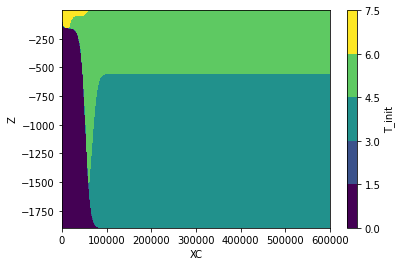

In [15]:
# Convert density into temperature
import okapy.thermo as okt

T_0, rho_0, alpha = 8, 1027, 2e-4

ds_input['rho_ref'] = ds_input['rho'].isel(XC=-1).fillna(0)

ds_input['T_ref'] = okt.T_from_rho(ds_input['rho_ref'], rho_0, alpha) + T_0
ds_input['T_init'] = (okt.T_from_rho(ds_input['rho'], rho_0, alpha) + T_0)
ds_input['T_init'] = ds_input['T_init'].fillna(1)

ds_input['T_init'].plot.contourf()

ds_input['S_ref'] = xr.zeros_like(ds_input['Z'])
ds_input['S_init'] = ds_input['S_ref'].broadcast_like(ds_input['XC'])

## Meridional wind stress
We want a meridional wind stress of around -50,000 Nsm$^{-2}$ lasting around 3 days. In terms of a length scale this is around 150 km - 200 km. Currently Ly = 3000 km, LNsponge = 300 km , LSsponge = 300 km. This means the domain is around 2400 km. This is probably way too big so we should make the domain muchos smaller....

The units are weird -- they look like a time integrated wind stress. Assuming they've integrated over an output timestep, of around 12 hours, this would give an instantaneous wind stress of around 1.2 Nm$^{-2}$. This seems very high, but I guess we're looking at very strong, low likelihood wind events so maybe this isn't all that bad?

So let's say 300 km Nsponge, then 500 km adjustment region, then 150 km to 200 km windy region, folleowed by another 500 km adjustment region and 300 km Ssponge giving a total of 1800 km. 

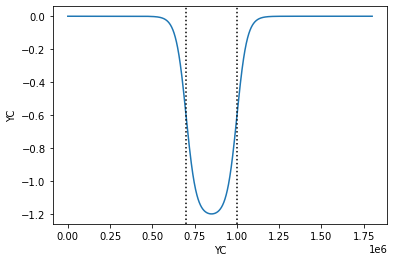

In [16]:
tau_y = - (np.tanh((ds_input['YC'] - (Ly - 800e3)) / 60e3)) + (np.tanh((ds_input['YC'] - (Ly - 1100e3)) / 60e3))
tau_y = tau_y / tau_y.max() * -1.2

tau_y.plot()
plt.axvline(Ly - 800e3, ls=':', c='k')
plt.axvline(Ly - 1100e3, ls=':', c='k')

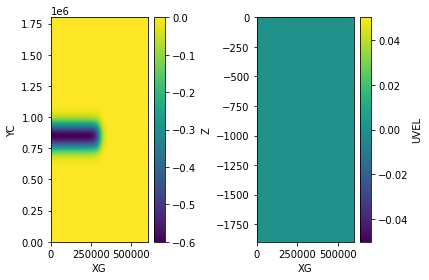

In [31]:
tau_y = np.exp(-(ds_input['YC'] - (Ly - 950e3)) ** 2/ (75e3) ** 2 / 2)
tau_y = tau_y / tau_y.max() * -0.6

xstar = 300e3
wwidth = 25e3
amplitude = (-np.tanh((ds_input['XG'] - xstar) / wwidth) + 1) * 0.5
tau_y = (tau_y * amplitude)

fig, axs = plt.subplots(1, 2)
tau_y.plot(ax=axs[0])

ds_input['merid_wind_stress'] = tau_y

zonal_wind = 'zero'


if zonal_wind == 'zero':
    tau_x = xr.zeros_like(ds_input['UVEL'])

elif zonal_wind == 'divergence_free':
    dtaux_dx = -grid.diff(tau_y, 'Y', boundary='fill') / dy
    tau_x = grid.cumsum(dtaux_dx, 'X') * dx

    skip = 1
    fig, ax = plt.subplots(figsize=(15, 15))
    #plt.streamplot(ds_input['XC'].values, ds_input['YC'].values, tau_x[::skip, ::skip], tau_y[::skip, ::skip], )
    #plt.gca().set_aspect('equal')

elif zonal_wind == 'irrotational':
    ## Irrotational winds

    dtaux_dy = grid.diff(ds_input['merid_wind_stress'], 'X') / dx

    tau_x = grid.cumsum(dtaux_dy, 'Y', boundary='fill') * dy 
    tau_x = tau_x - tau_x.max() * 0.5
    #tau_x.plot(robust=True)


ds_input['zonal_wind_stress'] = tau_x

tau_x.plot(ax=axs[1])
fig.tight_layout()

## Sponge

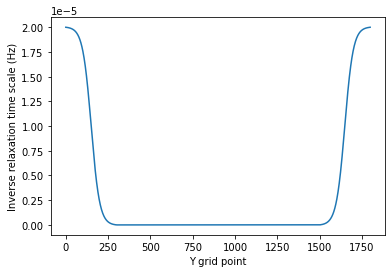

In [32]:
def sponge_gamma():
    L_Nsponge = 300
    gammamax= 2e-5
    delta_Nsponge = 50
    mid_Nsponge = L_Nsponge / 2
    Nsponge = np.arange(0, L_Nsponge + 1)
    gamma_Nsponge = (np.tanh((Nsponge - mid_Nsponge) / delta_Nsponge) - np.tanh(- mid_Nsponge / delta_Nsponge)) * gammamax / np.tanh(mid_Nsponge / delta_Nsponge) / 2

    L_Ssponge = 300
    gammamax= 2e-5
    delta_Ssponge = 50
    mid_Ssponge = L_Ssponge / 2
    Ssponge = np.arange(0, L_Ssponge + 1)
    gamma_Ssponge = (np.tanh((Ssponge - mid_Ssponge) / delta_Ssponge) - np.tanh(- mid_Ssponge / delta_Ssponge)) * gammamax / np.tanh(mid_Ssponge / delta_Ssponge) / 2
    gamma_Ssponge = gamma_Ssponge[::-1]

    L_interior = int(Ly / dy - L_Ssponge - L_Nsponge - 2)
    gamma_interior = np.zeros(L_interior)
    gamma_whole = np.concatenate((gamma_Ssponge, gamma_interior, gamma_Nsponge))
    return gamma_whole

gamma_whole = sponge_gamma()

plt.figure()
plt.plot(gamma_whole)
plt.xlabel('Y grid point')
plt.ylabel('Inverse relaxation time scale (Hz)')

ds_input['gammaV'] = xr.DataArray(gamma_whole, dims=('YG')).broadcast_like(ds_input['VVEL'])
ds_input['gammaU'] = xr.DataArray(gamma_whole, dims=('YC')).broadcast_like(ds_input['UVEL'])
ds_input['gammaT'] = xr.DataArray(gamma_whole, dims=('YC')).broadcast_like(ds_input['VVEL'])
ds_input['gammaS'] = xr.DataArray(gamma_whole, dims=('YC')).broadcast_like(ds_input['VVEL'])

## File check list
- UVEL init
- VVEL init
- VVEL North BC
- VVEL South BC
- Bathymetry (Y, X)
- dz
- T init
- T North BC
- T South BC
- T ref
- S init
- S ref
- gamma U
- gamma V
- gamma T
- gamma S
- meridional wind stress


In [33]:
variable_list = ['VVEL',
                 'UVEL',
                 'bathymetry',
                 #'deltaX',
                 #'deltaY',
                 #'deltaZ',
                 'T_init',
                 'T_ref',
                 #'T_bound',
                 'S_init',
                 'S_ref',
                 #'gammaU',
                 #'gammaV',
                 #'gammaT',
                 #'gammaS',
                 'merid_wind_stress',
                 'zonal_wind_stress'
                ]
for var in variable_list:
    print(var)
    ds_input[var] = ds_input[var].fillna(0)
ds_input

VVEL
UVEL
bathymetry
T_init
T_ref
S_init
S_ref
merid_wind_stress
zonal_wind_stress


<xarray.Dataset>
Dimensions:            (YC: 1800, YG: 1800, Z: 475, XC: 600, XG: 600, Zu: 475, Zl: 475)
Coordinates:
  * YC                 (YC) float64 0.0 1.001e+03 ... 1.799e+06 1.8e+06
  * YG                 (YG) float64 -500.0 500.6 1.501e+03 ... 1.798e+06 1.8e+06
  * Z                  (Z) float64 -2.0 -6.0 -10.0 ... -1.894e+03 -1.898e+03
  * XC                 (XC) float64 0.0 1.002e+03 2.003e+03 ... 5.99e+05 6e+05
  * XG                 (XG) float64 -500.0 501.7 ... 5.985e+05 5.995e+05
  * Zu                 (Zu) float64 -4.0 -8.0 -12.0 ... -1.896e+03 -1.9e+03
  * Zl                 (Zl) float64 0.0 -4.0 -8.0 ... -1.892e+03 -1.896e+03
    distance           (XC) float64 0.0 1.002e+03 2.003e+03 ... 5.99e+05 6e+05
    depth              (Z) float64 -2.0 -6.0 -10.0 ... -1.894e+03 -1.898e+03
Data variables: (12/22)
    deltaX             (XC) float64 1e+03 1e+03 1e+03 ... 1e+03 1e+03 1e+03
    deltaY             (YC) float64 1e+03 1e+03 1e+03 ... 1e+03 1e+03 1e+03
    deltaZ             (Z) float64 4.0 4.0 4.0 4.0 4.0 ... 4.0 4.0 4.0 4.0 4.0
    bathymetry         (XC) float64 -0.08142 -60.16 -96.58 ... -1.9e+03 -1.9e+03
    bool_land_mask     (Z, XC) int64 0 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1
    nan_land_mask      (Z, XC) float64 nan 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    ...                 ...
    merid_wind_stress  (YC, XG) float64 -7.706e-29 -7.706e-29 ... -3.407e-46
    zonal_wind_stress  (Z, XG) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    gammaV             (Z, XC, YG) float64 2e-05 2e-05 2e-05 ... 2e-05 2e-05
    gammaU             (Z, XG, YC) float64 2e-05 2e-05 2e-05 ... 2e-05 2e-05
    gammaT             (Z, XC, YC) float64 2e-05 2e-05 2e-05 ... 2e-05 2e-05
    gammaS             (Z, XC, YC) float64 2e-05 2e-05 2e-05 ... 2e-05 2e-05

In [35]:
def broadcast_to_3d_vars(ds_input):
    ds_3d = xr.Dataset()
    
    ds_3d['VVEL'] = ds_input['VVEL'].broadcast_like(ds_input['YG'])
    ds_3d['UVEL'] = ds_input['UVEL'].broadcast_like(ds_input['YC'])
    ds_3d['VVEL_bound'] = ds_input['VVEL']
    
    ds_3d['bathymetry'] = ds_input['bathymetry'].broadcast_like(ds_input['YC'])
    
    ds_3d['deltaX'] = ds_input['deltaX']
    ds_3d['deltaY'] = ds_input['deltaY']
    ds_3d['deltaZ'] = ds_input['deltaZ']

    ds_3d['T_bound'] = ds_input['T_init']
    ds_3d['T_init'] = ds_input['T_init'].broadcast_like(ds_input['YC'])
    ds_3d['T_ref'] = ds_input['T_ref']
 
    ds_3d['S_init'] = ds_input['S_init'].broadcast_like(ds_input['YC'])
    ds_3d['S_ref'] = ds_input['S_ref']
    
    ds_3d['gammaU'] = ds_input['gammaU']
    ds_3d['gammaV'] = ds_input['gammaV']
    ds_3d['gammaT'] = ds_input['gammaT']
    ds_3d['gammaS'] = ds_input['gammaS']
    
    ds_3d['merid_wind_stress'] = ds_input['merid_wind_stress']
    ds_3d['zonal_wind_stress'] = ds_input['zonal_wind_stress']
    ds_3d = ds_3d.transpose('Z', 'Zl', 'Zu', 'Zp1', 'YG', 'YC', 'XG', 'XC', missing_dims='ignore')
    return ds_3d

ds_3d = broadcast_to_3d_vars(ds_input)
ds_3d

<xarray.Dataset>
Dimensions:            (Z: 475, XC: 600, YG: 1800, XG: 600, YC: 1800)
Coordinates:
  * Z                  (Z) float64 -2.0 -6.0 -10.0 ... -1.894e+03 -1.898e+03
  * XC                 (XC) float64 0.0 1.002e+03 2.003e+03 ... 5.99e+05 6e+05
    distance           (XC) float64 0.0 1.002e+03 2.003e+03 ... 5.99e+05 6e+05
    depth              (Z) float64 -2.0 -6.0 -10.0 ... -1.894e+03 -1.898e+03
  * YG                 (YG) float64 -500.0 500.6 1.501e+03 ... 1.798e+06 1.8e+06
  * XG                 (XG) float64 -500.0 501.7 ... 5.985e+05 5.995e+05
  * YC                 (YC) float64 0.0 1.001e+03 ... 1.799e+06 1.8e+06
Data variables: (12/18)
    VVEL               (Z, YG, XC) float64 -0.0 -0.0 -0.02713 ... -0.0 -0.0 -0.0
    UVEL               (Z, YC, XG) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    VVEL_bound         (Z, XC) float64 -0.0 -0.0 -0.02713 ... -0.0 -0.0 -0.0
    bathymetry         (YC, XC) float64 -0.08142 -60.16 ... -1.9e+03 -1.9e+03
    deltaX             (XC) float64 1e+03 1e+03 1e+03 ... 1e+03 1e+03 1e+03
    deltaY             (YC) float64 1e+03 1e+03 1e+03 ... 1e+03 1e+03 1e+03
    ...                 ...
    gammaU             (Z, YC, XG) float64 2e-05 2e-05 2e-05 ... 2e-05 2e-05
    gammaV             (Z, YG, XC) float64 2e-05 2e-05 2e-05 ... 2e-05 2e-05
    gammaT             (Z, YC, XC) float64 2e-05 2e-05 2e-05 ... 2e-05 2e-05
    gammaS             (Z, YC, XC) float64 2e-05 2e-05 2e-05 ... 2e-05 2e-05
    merid_wind_stress  (YC, XG) float64 -7.706e-29 -7.706e-29 ... -3.407e-46
    zonal_wind_stress  (Z, XG) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

In [36]:
variable_list = ['VVEL',
                 'UVEL',
                 'VVEL_bound',
                 'bathymetry',
                 'deltaX',
                 'deltaY',
                 'deltaZ',
                 'T_init',
                 'T_ref',
                 'T_bound',
                 'S_init',
                 'S_ref',
                 'gammaU',
                 'gammaV',
                 'gammaT',
                 'gammaS',
                 'merid_wind_stress',
                 'zonal_wind_stress']

input_path = './run_right_wind/input'


for var in variable_list:
    fbase = osp.join(input_path, var)
    mds.wrmds(fbase, ds_3d[var].values, dataprec='float32')

In [37]:
scluster.close()